<a href="https://colab.research.google.com/github/valterlucena/recuperacao-informacao/blob/master/index-query/index_query.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

import collections
import matplotlib.pyplot as plt
%matplotlib inline

import heapq as hp
import time

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Introdução

Nessa atividade exercitaremos conceitos de indexação e processamento de consulta. Os dados utilizados são de textos de notícias resultados da utilização de técnicas de *crawling* e *scrapping*. Os *scripts* para a coleta desses dados podem ser encontrados [neste](https://github.com/valterlucena/ri_lab_01) repositório.

Primeiramente, vamos importar os dados que serão utilizados.

In [0]:
DATA_URL = 'https://raw.githubusercontent.com/valterlucena/ri_lab_01/master/output/results.csv'
news = pd.read_csv(DATA_URL).replace(np.nan, '', regex=True)

# Índice Invertido

Um índice é uma estrutura de dados projetada para tornar as buscas mais rápidas. O índice invertido é um nome genérico para uma classe de estruturas onde documentos são associados a palavras, ao invés de palavras a documentos.

A seguir, construiremos um índice invertido para os documentos (texto das notícias) da nossa base de dados. Utilizaremos a função `tokenize` da biblioteca [NLTK](https://www.nltk.org/) associada à uma expressão regular, que considerará como *token* apenas as sequências de caracteres não-especiais (com exceção do hífen) ou numéricos que não formem *stopwords*.

In [0]:
toker = RegexpTokenizer('''\w+[-']*\w*''')
stop_words = stopwords.words('portuguese')

def isValid(token):
  return token not in stop_words and not bool(re.search(r'\d', token))

def build_index(documents):
  index = {}
  n = 0
  for document in documents:
    n += 1
    tokens = [token for token in toker.tokenize(document.lower()) if isValid(token)]
    for token in tokens:
      occurrence = tokens.count(token)
      if token not in index:
        index[token] = {}
      if n not in index[token]:
        index[token][n] = occurrence
  return index

O índice invertido construído trata-se de dicionário que associa um termo à uma lista invertida. Essa lista invertida, por sua vez, é outro dicionário que mapeia um documento à quantidade de vezes em que o termo associado à lista ocorre. 

In [4]:
index = build_index(news.text)
for termo in list(index.keys())[:10]:
  print(termo, index[termo])

ministério {1: 2, 2: 4, 5: 7, 16: 1, 17: 2, 44: 2, 45: 3, 54: 1, 65: 2, 83: 5, 98: 2, 102: 1, 109: 2, 111: 2, 120: 4, 124: 2, 125: 1, 136: 1, 137: 1, 142: 2}
público {1: 3, 2: 4, 5: 1, 9: 1, 18: 2, 45: 1, 46: 1, 60: 1, 65: 1, 67: 1, 70: 1, 71: 1, 83: 2, 89: 3, 94: 1, 98: 1, 102: 1, 108: 1, 111: 1, 119: 1, 120: 5, 124: 2, 125: 1, 129: 1, 134: 1, 136: 1, 137: 1, 142: 1}
estado {1: 1, 2: 3, 10: 2, 16: 6, 17: 1, 18: 1, 35: 1, 37: 1, 43: 1, 44: 1, 50: 1, 64: 1, 65: 1, 71: 1, 75: 3, 82: 1, 83: 1, 89: 1, 91: 1, 93: 1, 99: 6, 109: 1, 112: 1, 118: 4, 120: 1, 124: 1, 126: 3, 129: 1, 134: 2, 141: 1, 142: 1}
paulo {1: 2, 5: 3, 18: 1, 27: 2, 29: 1, 37: 1, 39: 1, 51: 2, 52: 1, 63: 1, 65: 1, 69: 1, 75: 1, 78: 1, 85: 1, 86: 1, 89: 2, 94: 9, 105: 1, 107: 1, 108: 8, 115: 1, 117: 1, 122: 2, 123: 1, 124: 1, 132: 1, 141: 1, 142: 1}
requereu {1: 1}
junto {1: 1, 2: 1, 9: 1, 29: 1, 37: 1, 45: 1, 50: 1, 65: 1, 75: 2, 118: 1, 141: 3}
justiça {1: 4, 2: 2, 6: 1, 16: 3, 18: 1, 29: 1, 39: 1, 44: 1, 45: 5, 46: 3, 54

Agora, salvaremos o índice num arquivo csv.

In [0]:
data = {'token':list(index.keys()), 'oc_list':list(index.values())}
df = pd.DataFrame(data)
df.to_csv('index.csv')

# Abordagens de processamento de consulta

O processamento de consultas é bem mais eficiente quando utiliza um índice. Aqui, utilizaremos dois algoritmos para processamento de consultas: **documento-por-vez** (*document-at-a-time*) e **termo-por-vez** (*term-at-a-time*). 

Inicialmente, definiremos algumas funções auxiliares que serão usadas nos algoritmos.

In [0]:
def get_documents_from_index(index):
  documents = []
  for _, inverted in index.items():
    for document, _ in inverted.items():
      documents.append(document)
  documents = list(set(documents))
  return documents

def get_top_results(k, results):
  top = []
  for i in range(1, k+1):
    if results:
      current_top = hp._heappop_max(results)
      top.append(current_top)
  return top

A função `get_documents_from_index` retorna todos os documentos (representados por um inteiro identificador) da base de dados utilizada.

A função `get_top_results` retorna os `k` resultados mais relevantes da consulta realizada.

## Documento-por-vez

Neste algoritmo, são calculadas pontuações (*scores*) processando todas as listas invertidas associadas ao termos um documento por vez. A pontuação resultante em cada documento refere-se à soma das ocorrências dos termos da consulta.

In [0]:
def document_at_a_time_retrieval(query, index, k):
  inverted_lists = []
  results = []
  for term in query.split():
    inverted_list = index[term]
    inverted_lists.append(inverted_list)
  documents = get_documents_from_index(index)
  for document in documents:
    score = 0
    for inv_list in inverted_lists:
      for doc,occurrence in inv_list.items():
        if document == doc:
          score += occurrence
    results.append((score, document))
  hp._heapify_max(results)
  top = get_top_results(k, results)
  return top

## Termo-por-vez

Nesta abordagem, pontuações são acumuladas para documentos processando as listas de termos um termo de cada vez. 

In [0]:
def term_at_a_time_retrieval(query, index, k):
  accumulators = {}
  inverted_lists = []
  for term in query.split():
    inverted_list = index[term]
    inverted_lists.append(inverted_list)
  for inv_list in inverted_lists:
    for doc,occurrence in inv_list.items():
      if doc in accumulators:
        accumulators[doc] += occurrence
      else:
        accumulators[doc] = occurrence
  results = [(score, document) for document,score in accumulators.items()]
  hp._heapify_max(results)
  top = get_top_results(k, results)
  return top

## Eficiência

A seguir, executaremos cinco consultas de um termo utilizando cada algoritmo e compararemos seus tempos de execução.

In [0]:
termos = ['presidente', 'lula', 'bolsonaro', 'governo', 'federal']

Definidos os termos de consulta, vamos processá-los.

Primeiramente para a abordagem documento-por-vez.

In [0]:
tempo_execucao_datr = []
result_datr = []
for termo in termos:
  inicio = time.time()
  datr = document_at_a_time_retrieval(termo, index, 10)
  fim = time.time()
  tempo_execucao_datr.append(fim - inicio)
  result_datr.append(datr)

Agora para a abordagem termo-por-vez.

In [0]:
tempo_execucao_tatr = []
result_tatr = []
for termo in termos:
  inicio = time.time()
  tatr = term_at_a_time_retrieval(termo, index, 10)
  fim = time.time()
  tempo_execucao_tatr.append(fim - inicio)
  result_tatr.append(tatr)

Com os dados coletados durante os experimentos, podemos montar um *dataframe*.


In [12]:
pd.options.display.max_colwidth = 160
queries = pd.DataFrame()
queries['termo'] = termos
queries['document_at_a_time'] = result_datr
queries['tempo_doc'] = tempo_execucao_datr
queries['term_at_a_time'] = result_tatr
queries['tempo_term'] = tempo_execucao_tatr
queries

,termo,document_at_a_time,tempo_doc,term_at_a_time,tempo_term
0,presidente,"[(9, 75), (8, 99), (8, 65), (6, 136), (6, 45), (5, 98), (5, 94), (5, 15), (4, 93), (4, 10)]",0.008655,"[(9, 75), (8, 99), (8, 65), (6, 136), (6, 45), (5, 98), (5, 94), (5, 15), (4, 93), (4, 10)]",0.000057
1,lula,"[(78, 117), (22, 120), (17, 29), (15, 64), (9, 99), (8, 123), (8, 50), (7, 111), (5, 125), (3, 89)]",0.008370,"[(78, 117), (22, 120), (17, 29), (15, 64), (9, 99), (8, 123), (8, 50), (7, 111), (5, 125), (3, 89)]",0.000021
2,bolsonaro,"[(17, 99), (8, 136), (8, 105), (8, 98), (7, 75), (6, 137), (6, 101), (6, 45), (6, 15), (5, 73)]",0.009048,"[(17, 99), (8, 136), (8, 105), (8, 98), (7, 75), (6, 137), (6, 101), (6, 45), (6, 15), (5, 73)]",0.000037
3,governo,"[(11, 98), (8, 45), (7, 75), (7, 50), (6, 136), (6, 108), (6, 60), (6, 39), (5, 134), (5, 118)]",0.009045,"[(11, 98), (8, 45), (7, 75), (7, 50), (6, 136), (6, 108), (6, 60), (6, 39), (5, 134), (5, 118)]",0.000056
4,federal,"[(12, 120), (7, 141), (4, 142), (3, 98), (3, 45), (3, 2), (2, 137), (2, 136), (2, 134), (2, 123)]",0.009119,"[(12, 120), (7, 141), (4, 142), (3, 98), (3, 45), (3, 2), (2, 137), (2, 136), (2, 134), (2, 123)]",0.000028


Graficamente, temos:

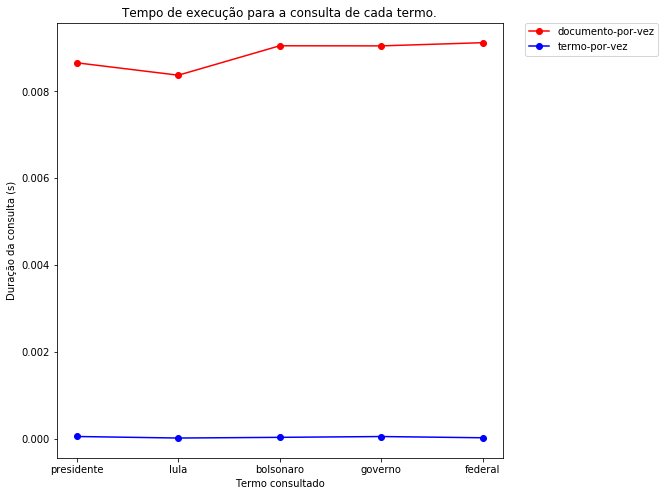

In [13]:
f, ax = plt.subplots(figsize=(8,8))
plt.plot(queries['termo'], queries['tempo_doc'], linestyle="-", marker="o", color="red", label="documento-por-vez")
plt.plot(queries['termo'], queries['tempo_term'], linestyle="-", marker="o", color="blue", label="termo-por-vez")
plt.title('Tempo de execução para a consulta de cada termo.')
plt.xlabel('Termo consultado')
plt.ylabel('Duração da consulta (s)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Neste gráfico, podemos observar que as consultas utilizando a abordagem documento-por-vez são mais lentas que utilizando a termo-por-vez. Isso se deve ao fato de que todos os documentos do índice são recuperados antes de cada consulta, e verificados um de cada vez.

Comparando o tempo médio, chegamos à mesma conclusão.

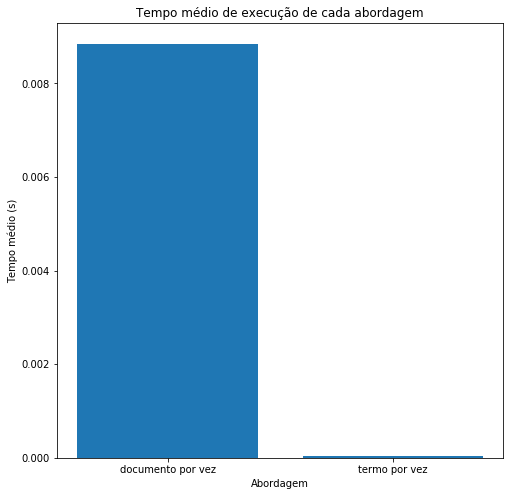

In [14]:
abordagem = ['documento por vez', 'termo por vez']
mean = [np.mean(tempo_execucao_datr), np.mean(tempo_execucao_tatr)]

f, ax = plt.subplots(figsize=(8,8))
plt.bar(abordagem, mean)
plt.title('Tempo médio de execução de cada abordagem')
plt.xlabel('Abordagem')
plt.ylabel('Tempo médio (s)')
plt.show()